# NLP

3 steps for using transfer learning:

#### 1. Some people train a **language model** like ImageNet for vision

- A language model is a model that tries to predict the next word of a sentence.
- Learn from wikipedia (Wikitext 103 dataset) (1 bilion tokens)
- Unsupervised learning of better: self-supervised learning becouse the label is in the data.
- You should have a language model on the same language you data is, or even not a language, like:
  - English
  - Chinese
  - Gnome sequences
  - Molecular data

#### 2. You finetune (retrain) the **language model** for your data
- This is very important to better know your kind of text data.
- It can take very long to train it (5 hours or a night).
- But you have to train it only once for your corpus data.
- You are only interested in save the encoder part of your language model.

#### 3. You use the langage model encoder for your particular task
- A task like a classifier
- The decoder will be different.
- This training is faster (10 or 30 mins)

In [1]:
from fastai.text import *

## Download IMDB dataset

In [18]:
bs=48
path = untar_data(URLs.IMDB)
path.ls()

[WindowsPath('C:/Users/Javi/.fastai/data/imdb/imdb.vocab'),
 WindowsPath('C:/Users/Javi/.fastai/data/imdb/README'),
 WindowsPath('C:/Users/Javi/.fastai/data/imdb/test'),
 WindowsPath('C:/Users/Javi/.fastai/data/imdb/tmp_clas'),
 WindowsPath('C:/Users/Javi/.fastai/data/imdb/tmp_lm'),
 WindowsPath('C:/Users/Javi/.fastai/data/imdb/train'),
 WindowsPath('C:/Users/Javi/.fastai/data/imdb/unsup')]

In [19]:
(path/'train').ls()

[WindowsPath('C:/Users/Javi/.fastai/data/imdb/train/labeledBow.feat'),
 WindowsPath('C:/Users/Javi/.fastai/data/imdb/train/neg'),
 WindowsPath('C:/Users/Javi/.fastai/data/imdb/train/pos'),
 WindowsPath('C:/Users/Javi/.fastai/data/imdb/train/unsupBow.feat')]

## Language model: Get the data

We can feed words directly to our neural net. We first have to convert them to numbers. This is done in two differents steps:
1. **Tokenization**: Split the text into words, or more exactly tokens.
   - We need to take care of punctuation
   - Some words are contractions of two different words.
2. **Numericalization**: Convert to integers
   - Create a list of all the words used.
   - Keep only the ones that appear more than twice with a maximum vocabulary size of 60000
   
Note that we can use the test data because we only care about predictiong the next word. Not the actual classification task.

Takes a few minutes to tokenize and numerize. So we save it for a quick load later.

In [20]:
#data = TextClasDataBunch.load(path)

# data = (TextList.from_csv(path, 'texts.csv', cols='text')
#                .split_from_df(col=2)
#                .label_from_df(cols=0)
#                .databunch())
            
data_lm = (TextList.from_folder(path) #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('tmp_lm')

In [21]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=bs)

In [22]:
data_lm.show_batch()

idx,text
0,"xxbos xxmaj okay , let 's face it , this movie is trite . i was expecting a much better film , never mind better cinematography . xxmaj but it 's slow , tired and worn . xxmaj the trailer was a better film than the movie ... it moved , it had action and it left you wanting more . \n\n xxmaj the story starts off slowly , and"
1,""" xxmaj scared xxmaj to xxmaj death "" is probably best remembered , if indeed it 's remembered at all , as xxmaj bela xxmaj lugosi 's only color film . xxmaj unfortunately , it was also one of his worst . i had a hard time trying to figure out just what was going on . xxmaj was it a mystery or a comedy or an attempt at something"
2,"ravishing model with some xxunk mental traumas , moves into a stunning brownstone apartment in xxmaj brooklyn , deeply against the will of her boyfriend xxmaj michael who proposed to we d her several times already . xxmaj alison 's physical existence and especially her mental condition drastically alter shortly after , and the ominous apartment appears to be the root of all misery . xxmaj she meets eccentric neighbors"
3,"about the horror and morality about an issue of a scientific level , while ' xxmaj the xxmaj body xxmaj snatcher ' was more a character driven film that looked how guilt , greed and pride can personally destroy someone by becoming an unwanted ordeal . xxmaj even this was more graphic in its depiction of the continuous violence that it becomes a real unsettling mix , especially on how"
4,"about whether or not he is making the right choice , i cried . xxmaj actually ... crying is sort of an xxunk i bawled . \n\n xxmaj even though i know that the xxmaj care xxmaj bears are not real ... and in fact are xxunk i still view them as real beings and follow their actions by caring . xxmaj this movie is cute , funny , sad"


## Language model: Train
We'll use a RNN model pretrained on a bigger dataset [wikitext-103](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/).

It takes a very loooooooooooooooooooooooooooong time to train it.

In [23]:
learn = language_model_learner(data_lm,
                               pretrained_model=URLs.WT103_1,
                               drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


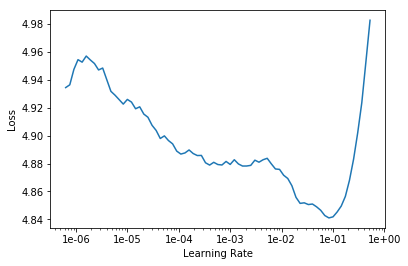

In [24]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [25]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,4.239668,4.057655,0.292542


Now we should unfreeze and train again bat meh... Let's save it.

In [26]:
learn.save('lang_model')

We really only want the encoder for use it for other task. Becaose the decoder is in charge of predect the next word.

In [27]:
learn.save_encoder('lang_model_enc')

## Language model: Test

In [29]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because memorize frisson larcenous aligned serbs ff8 zora citations elicot malley peril glistening tipoff starlina trading fairfax devouring dao clanking dhol balling team soweto insinuating 1910 waiter ticks insubordination hg mme beaudine geriatric rashid jay heartbreak bubba kentucky assignments tomfoolery :-(
I liked this movie because argentine reconciling gawain tora zeitgeist tragedy burrell 11:30pm alyce overacts tresdodge götz meyer bonkers stiff ic transferred rhythmic reflecting swathed resigns foxworthy alfre lineage .-- amsterdamn colony splendour rossito americanism barnabas peoples adventurers achievers keyser quintessentially volunteering giganten bostwick radek


==========================================================================
## Classifier: Get data
Note that we pass the same vaocb from the language model. Because we want to make sure that the words have the same number. Otherwise the pretrained language model is useless.

In [30]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('tmp_clas')

In [31]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=bs)

In [32]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos i thought that xxup rotj was clearly the best out of the three xxmaj star xxmaj wars movies . i find it surprising that xxup rotj is considered the weakest installment in the xxmaj trilogy by many who have voted . xxmaj to me it seemed like xxup rotj was the best because it had the most profound plot , the most suspense , surprises , most xxunk the",pos
"xxbos xxmaj an xxmaj american xxmaj in xxmaj paris is an integrated musical , meaning that the songs and dances blend perfectly with the story . xxmaj the film was inspired by the 1928 orchestral composition by xxmaj george xxmaj gershwin . \n\n xxmaj the story of the film is interspersed with show - stopping dance numbers choreographed by xxmaj gene xxmaj kelly and set to popular xxmaj gershwin tunes",pos
"xxbos xxmaj obsession comes in many flavors , and exists for a variety of reasons ; for some it may be nothing more than a compulsive disorder , but for others it may be an avenue of survival . xxmaj lack of nurturing , combined with an inability to negotiate even the simplest necessities of daily life or the basic social requirements , may compel even a genius to enthusiastically",pos
"xxbos xxmaj scarecrows is one of those films that , with a little more acting , a little more direction , and a lot more story logic , would have been quite compelling as a horror entry . xxmaj as it stands , it is still a creepy film that has solid make - up and gore effects , and a premise that sustains the mood of terror in spite",neg


## Classifier: Train

In [33]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('lang_model_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


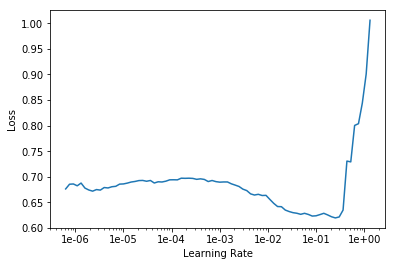

In [34]:
learn.lr_find()
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.503790,0.361526,0.848560


## Classifier: Test

In [36]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([0.0017, 0.9983]))